In [2]:
import os
import csv
import cv2 # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import random
import shutil
from skimage.measure import label as sk_label, regionprops
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

In [3]:
def preprocess_image(image_path):
    """
    Applique les traitements nécessaires pour améliorer l'image avant son utilisation.
    - Histogramme d'étirement pour augmenter le contraste.
    - Binarisation adaptative.
    - Érosion et dilatation pour réduire le bruit.
    - Filtrage de petites régions.
    - Recadrage automatique pour isoler le chiffre.
    """
    # Charger l'image en niveaux de gris
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Erreur : Impossible de charger l'image {image_path}")
        return None

    # Appliquer un étirement de l'histogramme pour améliorer le contraste
    min_val, max_val = np.min(img), np.max(img)
    stretched = ((img - min_val) / (max_val - min_val)) * 255
    stretched = stretched.astype(np.uint8)

    # Appliquer un flou gaussien pour réduire le bruit
    blurred = cv2.GaussianBlur(stretched, (5, 5), 0)

    # Binarisation adaptative pour gérer les variations locales
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Appliquer une érosion pour affiner les contours
    kernel = np.ones((2, 2), np.uint8)  # Kernel de taille 2x2
    eroded = cv2.erode(binary, kernel, iterations=1)

    # Appliquer une dilatation pour renforcer les chiffres après érosion
    dilated = cv2.dilate(eroded, kernel, iterations=1)

    # Trouver les contours pour recadrer l'image autour du chiffre
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Trouver le plus grand contour (supposé être le chiffre)
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Recadrer l'image autour du chiffre
        cropped = dilated[y:y+h, x:x+w]
    else:
        print(f"Aucun chiffre détecté dans l'image {image_path}")
        return None

    # Redimensionner l'image à une taille standard (par exemple, 28x28)
    resized = cv2.resize(cropped, (28, 28), interpolation=cv2.INTER_AREA)

    return resized


In [4]:
def collect_and_process_images(root_folder, output_csv, features_csv):
    """
    Traite les images et enregistre les caractéristiques et les chemins des images traitées.
    """
    dataset = {str(i): [] for i in range(10)}
    features = []
    labels = []

    # Dossier pour sauvegarder les images prétraitées
    processed_images_dir = "processed_images"
    os.makedirs(processed_images_dir, exist_ok=True)

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if file.endswith(('.jpg', '.jpeg')):
                # Normaliser le chemin pour gérer les caractères spéciaux
                full_path = os.path.normpath(os.path.join(subdir, file))
                print(f"Chargement de l'image {full_path}")  # Vérification du chemin de l'image

                digit_label = file.split('.')[0]  # Renommé pour éviter conflit avec la fonction label
                if digit_label in dataset:
                    # Prétraitement de l'image
                    processed_img = preprocess_image(full_path)
                    if processed_img is None:
                        continue  # Si l'image n'est pas traitée, on passe à la suivante

                    # Créer un sous-dossier pour chaque chiffre dans le dossier processed_images
                    digit_folder = os.path.join(processed_images_dir, digit_label)
                    os.makedirs(digit_folder, exist_ok=True)

                    # Sauvegarder l'image prétraitée dans le dossier correspondant au chiffre
                    image_count = len(dataset[digit_label]) + 1
                    processed_path = os.path.join(digit_folder, f"{digit_label}_{image_count}.jpg")
                    if cv2.imwrite(processed_path, processed_img):
                        print(f"Image sauvegardée : {processed_path}")
                    else:
                        print(f"Erreur lors de la sauvegarde de l'image : {processed_path}")
                    dataset[digit_label].append(processed_path)

                    # Extraire les caractéristiques
                    labeled = sk_label(processed_img)  # Utiliser l'alias pour la fonction label
                    props = regionprops(labeled)
                    for region in props:
                        features.append([ 
                            region.area, 
                            region.eccentricity, 
                            region.major_axis_length / region.minor_axis_length if region.minor_axis_length > 0 else 0, 
                            region.orientation 
                        ])
                        labels.append(digit_label)

    # Sauvegarder les chemins des images dans un CSV
    with open(output_csv, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["image_path", "label"])
        for label, images in dataset.items():
            for image_path in images:
                writer.writerow([image_path, label])

    # Sauvegarder les caractéristiques dans un CSV
    with open(features_csv, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["area", "eccentricity", "aspect_ratio", "orientation", "label"])
        for feat, lbl in zip(features, labels):
            writer.writerow(feat + [lbl])

    print(f"Images prétraitées sauvegardées dans : {processed_images_dir}")
    print(f"Chemins des images sauvegardés dans : {output_csv}")
    print(f"Caractéristiques sauvegardées dans : {features_csv}")


In [5]:
root_folder = "root"  # Remplacez par le chemin vers le dossier principal
output_csv = "dataset.csv"
features_csv = "features.csv"
collect_and_process_images(root_folder, output_csv, features_csv)

Chargement de l'image root\Abed-Nego GNANGUENON\0.jpg
Image sauvegardée : processed_images\0\0_1.jpg
Chargement de l'image root\Abed-Nego GNANGUENON\1.jpg
Image sauvegardée : processed_images\1\1_1.jpg
Chargement de l'image root\Abed-Nego GNANGUENON\2.jpeg
Image sauvegardée : processed_images\2\2_1.jpg
Chargement de l'image root\Abed-Nego GNANGUENON\3.jpg
Image sauvegardée : processed_images\3\3_1.jpg
Chargement de l'image root\Abed-Nego GNANGUENON\4.jpg
Image sauvegardée : processed_images\4\4_1.jpg
Chargement de l'image root\Abed-Nego GNANGUENON\5.jpg
Image sauvegardée : processed_images\5\5_1.jpg
Chargement de l'image root\Abed-Nego GNANGUENON\6.jpg
Image sauvegardée : processed_images\6\6_1.jpg
Chargement de l'image root\Abed-Nego GNANGUENON\7.jpg
Image sauvegardée : processed_images\7\7_1.jpg
Chargement de l'image root\Abed-Nego GNANGUENON\8.jpg
Image sauvegardée : processed_images\8\8_1.jpg
Chargement de l'image root\Abed-Nego GNANGUENON\9.jpg
Image sauvegardée : processed_images

KeyboardInterrupt: 

In [6]:
# Fonction pour charger l'image à partir du chemin
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Lire en niveaux de gris
    if img is None:
        print(f"Erreur de chargement de l'image : {image_path}")
    return img

# Fonction pour traiter l'image (binarisation et érosion)
def preprocess_image(img):
    _, binarized_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)  # Binarisation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Érosion
    eroded_img = cv2.erode(binarized_img, kernel, iterations=1)
    return eroded_img

# Fonction pour afficher l'image avec son label
def display_image_with_label(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(f"Label : {label}")
    plt.axis('off')  # Ne pas afficher les axes
    plt.show()

# Fonction pour charger la base de données (CSV) des images et labels
def load_image_database(csv_file):
    df = pd.read_csv(csv_file)  # Lire le fichier CSV
    return df

# Fonction pour afficher une image à un index donné
def display_image_from_database(database, index):
    if index < len(database):
        row = database.iloc[index]
        image_path = row['image_path']
        label = row['label']
        
        # Charger et traiter l'image
        img = load_image(image_path)
        processed_img = preprocess_image(img)
        
        # Afficher l'image avec son label
        display_image_with_label(processed_img, label)
    else:
        print(f"Index {index} hors des limites de la base de données.")


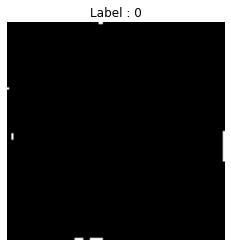

In [12]:
csv_file = "test_dataset.csv"  
database = load_image_database(csv_file)

# Afficher l'image et son label
index = 1
display_image_from_database(database, index)

In [119]:
def split_dataset(root_folder, train_folder, test_folder, output_csv_train, output_csv_test, test_ratio=0.2):
    """
    Sépare la base de données en ensembles d'entraînement et de test, et sauvegarde les images dans les dossiers appropriés.
    """
    # Créer les dossiers d'entraînement et de test
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Initialiser les listes pour les CSV
    train_data = []
    test_data = []

    # Parcourir les dossiers des chiffres (0 à 9)
    for digit in range(10):
        digit_folder = os.path.join(root_folder, str(digit))
        if not os.path.exists(digit_folder):
            continue

        # Lister toutes les images pour ce chiffre
        images = [f for f in os.listdir(digit_folder) if f.endswith('.jpg') or f.endswith('.jpeg')]
        random.shuffle(images)  # Mélanger les images aléatoirement

        # Calculer le nombre d'images pour l'entraînement (80%) et pour le test (20%)
        num_train = int(len(images) * (1 - test_ratio))
        num_test = len(images) - num_train

        # Séparer les images en ensembles d'entraînement et de test
        train_images = images[:num_train]
        test_images = images[num_train:]

        # Déplacer les images vers les dossiers train et test
        for img in train_images:
            src_path = os.path.join(digit_folder, img)
            dest_folder = os.path.join(train_folder, str(digit))
            os.makedirs(dest_folder, exist_ok=True)
            shutil.copy(src_path, dest_folder)
            train_data.append([os.path.join(dest_folder, img), str(digit)])

        for img in test_images:
            src_path = os.path.join(digit_folder, img)
            dest_folder = os.path.join(test_folder, str(digit))
            os.makedirs(dest_folder, exist_ok=True)
            shutil.copy(src_path, dest_folder)
            test_data.append([os.path.join(dest_folder, img), str(digit)])

    # Sauvegarder les chemins des images dans les CSV
    with open(output_csv_train, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["image_path", "label"])
        for row in train_data:
            writer.writerow(row)

    with open(output_csv_test, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["image_path", "label"])
        for row in test_data:
            writer.writerow(row)

    print(f"Ensemble d'entraînement sauvegardé dans : {train_folder}")
    print(f"Ensemble de test sauvegardé dans : {test_folder}")
    print(f"Chemins des images d'entraînement sauvegardés dans : {output_csv_train}")
    print(f"Chemins des images de test sauvegardés dans : {output_csv_test}")

# Exemple d'utilisation
root_folder = "processed_images"  # Dossier contenant toutes les images prétraitées
train_folder = "train"  # Dossier où les images d'entraînement seront sauvegardées
test_folder = "test"  # Dossier où les images de test seront sauvegardées
output_csv_train = "train_dataset.csv"  # CSV pour les images d'entraînement
output_csv_test = "test_dataset.csv"  # CSV pour les images de test

split_dataset(root_folder, train_folder, test_folder, output_csv_train, output_csv_test)


Ensemble d'entraînement sauvegardé dans : train
Ensemble de test sauvegardé dans : test
Chemins des images d'entraînement sauvegardés dans : train_dataset.csv
Chemins des images de test sauvegardés dans : test_dataset.csv


In [13]:
# Paramètres
image_size = (28, 28)  # Redimensionner toutes les images à 50x50 pixels

k_neighbors = 3  # Nombre de voisins pour KNN

def load_dataset(csv_file):
    """
    Charge les images et les labels à partir d'un fichier CSV.
    Les images sont redimensionnées et transformées en vecteurs de caractéristiques.
    """
    data = pd.read_csv(csv_file)
    features = []
    labels = []
    for index, row in data.iterrows():
        image_path = row["image_path"]
        label = int(row["label"])

        # Charger l'image et la prétraiter
        if os.path.exists(image_path):
            img = imread(image_path, as_gray=True)  # Charger en niveaux de gris
            img_resized = resize(img, image_size, anti_aliasing=True)  # Redimensionner
            img_flattened = img_resized.flatten()  # Aplatir l'image en un vecteur
            features.append(img_flattened)
            labels.append(label)
        else:
            print(f"Image introuvable : {image_path}")

    return np.array(features), np.array(labels)

# Charger les ensembles d'entraînement et de test
train_csv = "train_dataset.csv"  # Chemin vers le fichier CSV d'entraînement
test_csv = "test_dataset.csv"  # Chemin vers le fichier CSV de test

X_train, y_train = load_dataset(train_csv)
X_test, y_test = load_dataset(test_csv)

print(f"Ensemble d'entraînement : {X_train.shape} images, {len(y_train)} labels")
print(f"Ensemble de test : {X_test.shape} images, {len(y_test)} labels")

# Entraîner le modèle KNN
knn = KNeighborsClassifier(n_neighbors=k_neighbors)
knn.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = knn.predict(X_test)

# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle KNN : {accuracy * 100:.2f}%")



Ensemble d'entraînement : (376, 784) images, 376 labels
Ensemble de test : (100, 784) images, 100 labels
Précision du modèle KNN : 49.00%


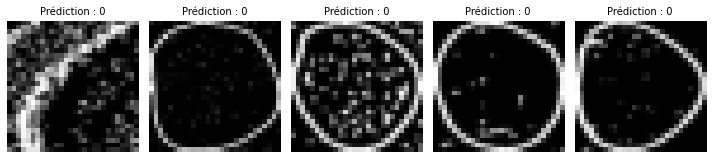

Image 1 -> Vrai : 0 | Prédit : 0
Image 2 -> Vrai : 0 | Prédit : 0
Image 3 -> Vrai : 0 | Prédit : 0
Image 4 -> Vrai : 0 | Prédit : 0
Image 5 -> Vrai : 0 | Prédit : 0
Image 6 -> Vrai : 0 | Prédit : 0
Image 7 -> Vrai : 0 | Prédit : 0
Image 8 -> Vrai : 0 | Prédit : 0
Image 9 -> Vrai : 0 | Prédit : 0
Image 10 -> Vrai : 0 | Prédit : 5
Image 11 -> Vrai : 1 | Prédit : 1
Image 12 -> Vrai : 1 | Prédit : 3
Image 13 -> Vrai : 1 | Prédit : 1
Image 14 -> Vrai : 1 | Prédit : 3
Image 15 -> Vrai : 1 | Prédit : 9
Image 16 -> Vrai : 1 | Prédit : 1
Image 17 -> Vrai : 1 | Prédit : 1
Image 18 -> Vrai : 1 | Prédit : 7
Image 19 -> Vrai : 1 | Prédit : 1
Image 20 -> Vrai : 1 | Prédit : 1
Image 21 -> Vrai : 2 | Prédit : 7
Image 22 -> Vrai : 2 | Prédit : 1
Image 23 -> Vrai : 2 | Prédit : 1
Image 24 -> Vrai : 2 | Prédit : 2
Image 25 -> Vrai : 2 | Prédit : 2
Image 26 -> Vrai : 2 | Prédit : 2
Image 27 -> Vrai : 2 | Prédit : 5
Image 28 -> Vrai : 2 | Prédit : 2
Image 29 -> Vrai : 2 | Prédit : 5
Image 30 -> Vrai : 2 | 

In [24]:

# Afficher les premières images de l'ensemble de test avec leurs prédictions
num_images = 5  # Nombre d'images à afficher
plt.figure(figsize=(10, 5))  # Définir la taille de la figure

for i in range(num_images):
    plt.subplot(2, 5, i + 1)  # Créer une grille 2x5 pour afficher les images
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')  # Remplacez 28x28 par 30x30 si vos images sont de cette taille
    plt.title(f"Prédiction : {y_pred[i]}", fontsize=10)  # Ajouter la prédiction en titre
    plt.axis('off')  # Supprimer les axes pour une meilleure visibilité

plt.tight_layout()  # Ajuster l'espacement entre les images
plt.show()


# Imprimer toutes les prédictions et vraies étiquettes
for i in range(len(y_test)):
    print(f"Image {i + 1} -> Vrai : {y_test[i]} | Prédit : {y_pred[i]}")

In [122]:
# Paramètres
image_size = (28, 28)  # Redimensionner toutes les images à 50x50 pixels
k_neighbors = 3  # Nombre de voisins pour KNN

def load_dataset(csv_file):
    """
    Charge les images et les labels à partir d'un fichier CSV.
    Les images sont redimensionnées et transformées en vecteurs de caractéristiques.
    """
    data = pd.read_csv(csv_file)
    features = []
    labels = []
    for index, row in data.iterrows():
        image_path = row["image_path"]
        label = int(row["label"])

        # Charger l'image et la prétraiter
        if os.path.exists(image_path):
            img = imread(image_path, as_gray=True)  # Charger en niveaux de gris
            img_resized = resize(img, image_size, anti_aliasing=True)  # Redimensionner
            img_flattened = img_resized.flatten()  # Aplatir l'image en un vecteur
            features.append(img_flattened)
            labels.append(label)
        else:
            print(f"Image introuvable : {image_path}")

    return np.array(features), np.array(labels)

# Charger les ensembles d'entraînement et de test
train_csv = "train_dataset.csv"  # Chemin vers le fichier CSV d'entraînement
test_csv = "test_dataset.csv"  # Chemin vers le fichier CSV de test

# Initialisation de la précision
accuracy = 0

# Continue à entraîner jusqu'à ce que la précision soit >= 0.51
while accuracy <= 0.48:
    # Charger les ensembles d'entraînement et de test après chaque nouvelle tentative
    X_train, y_train = load_dataset(train_csv)
    X_test, y_test = load_dataset(test_csv)

    print(f"Ensemble d'entraînement : {X_train.shape} images, {len(y_train)} labels")
    print(f"Ensemble de test : {X_test.shape} images, {len(y_test)} labels")

    # Entraîner le modèle KNN
    knn = KNeighborsClassifier(n_neighbors=k_neighbors)
    knn.fit(X_train, y_train)

    # Prédire sur l'ensemble de test
    y_pred = knn.predict(X_test)

    # Calculer la précision
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Précision du modèle KNN : {accuracy * 100:.2f}%")

    # Si la précision est inférieure ou égale à 0.50, diviser à nouveau les ensembles
    if accuracy <= 0.48:
        print("Précision insuffisante, nouvelle tentative...")
        split_dataset(root_folder, train_folder, test_folder, output_csv_train, output_csv_test)

print(f"Précision du modèle KNN atteint : {accuracy * 100:.2f}%")


Ensemble d'entraînement : (376, 784) images, 376 labels
Ensemble de test : (100, 784) images, 100 labels
Précision du modèle KNN : 44.00%
Précision insuffisante, nouvelle tentative...
Ensemble d'entraînement sauvegardé dans : train
Ensemble de test sauvegardé dans : test
Chemins des images d'entraînement sauvegardés dans : train_dataset.csv
Chemins des images de test sauvegardés dans : test_dataset.csv
Ensemble d'entraînement : (376, 784) images, 376 labels
Ensemble de test : (100, 784) images, 100 labels
Précision du modèle KNN : 37.00%
Précision insuffisante, nouvelle tentative...
Ensemble d'entraînement sauvegardé dans : train
Ensemble de test sauvegardé dans : test
Chemins des images d'entraînement sauvegardés dans : train_dataset.csv
Chemins des images de test sauvegardés dans : test_dataset.csv
Ensemble d'entraînement : (376, 784) images, 376 labels
Ensemble de test : (100, 784) images, 100 labels
Précision du modèle KNN : 39.00%
Précision insuffisante, nouvelle tentative...
Ense

In [20]:

# Imprimer toutes les prédictions et vraies étiquettes
for i in range(len(y_test)):
    print(f"Image {i + 1} -> Vrai : {y_test[i]} | Prédit : {y_pred[i]}")

Image 1 -> Vrai : 0 | Prédit : 0
Image 2 -> Vrai : 0 | Prédit : 0
Image 3 -> Vrai : 0 | Prédit : 0
Image 4 -> Vrai : 0 | Prédit : 0
Image 5 -> Vrai : 0 | Prédit : 0
Image 6 -> Vrai : 0 | Prédit : 0
Image 7 -> Vrai : 0 | Prédit : 0
Image 8 -> Vrai : 0 | Prédit : 0
Image 9 -> Vrai : 0 | Prédit : 0
Image 10 -> Vrai : 0 | Prédit : 5
Image 11 -> Vrai : 1 | Prédit : 1
Image 12 -> Vrai : 1 | Prédit : 3
Image 13 -> Vrai : 1 | Prédit : 1
Image 14 -> Vrai : 1 | Prédit : 3
Image 15 -> Vrai : 1 | Prédit : 9
Image 16 -> Vrai : 1 | Prédit : 1
Image 17 -> Vrai : 1 | Prédit : 1
Image 18 -> Vrai : 1 | Prédit : 7
Image 19 -> Vrai : 1 | Prédit : 1
Image 20 -> Vrai : 1 | Prédit : 1
Image 21 -> Vrai : 2 | Prédit : 7
Image 22 -> Vrai : 2 | Prédit : 1
Image 23 -> Vrai : 2 | Prédit : 1
Image 24 -> Vrai : 2 | Prédit : 2
Image 25 -> Vrai : 2 | Prédit : 2
Image 26 -> Vrai : 2 | Prédit : 2
Image 27 -> Vrai : 2 | Prédit : 5
Image 28 -> Vrai : 2 | Prédit : 2
Image 29 -> Vrai : 2 | Prédit : 5
Image 30 -> Vrai : 2 | 